# <div style="text-align: center"> find the physical link between Cloud and the others

              


In [1]:
import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import GEO_PLOT
import RESEARCH


In [2]:

import matplotlib
import matplotlib.pyplot as plt
from sklearn import datasets

import pandas as pd
import numpy as np
import seaborn as sns

In [45]:
def plot_learning_curve(model, scr_train, scr_test, feature_names, fig_name='learning_curve.png'):
    """
    using train and test valid datasets, but the showing "testing curve"
    model:
    evalSet:
    :return:
    """

    # plotting:

    result = model.evals_result()

    plt.figure(figsize=(8, 8))

    plt.plot(result['validation_0']['rmse'], label='train=%f' % scr_train, color='blue')
    plt.plot(result['validation_1']['rmse'], label='test=%f' % scr_test, color='red')

    # Add text to the top-left of the figure
    plt.text(0.15, 0.75, f'{len(feature_names)} features: {feature_names}',
             fontsize=12, color='green', transform=plt.gca().transAxes, verticalalignment='top')

    plt.tick_params(labelsize=14)
    plt.ylabel('', fontsize=148)
    plt.xlabel('', fontsize=148)
    plt.title("Learning curve RMSE (Stepwise_Feature_Elimination)", fontsize=14)
    plt.legend(prop={'size': 15})
    plt.ylim([0.06, 0.22])
    plt.savefig(f'./{fig_name:s}')
    plt.show()


## 1. Téléchargement et visualiation des données


In [ ]:
with_time = 1
shuffle=False

X_train, y_train, X_valid, y_valid, X_test, y_test, \
    X_train_scaled, X_valid_scaled, X_test_scaled, evalSet, df_raw = \
        RESEARCH.prepare_data(train_valid_rate=0.2, with_time=with_time, shuffle=shuffle)
print(X_train.head())
print(X_train.shape, X_valid.shape, X_test.shape)


Index(['GSW', 'SWDir', 'SWDif', 'LWdn', 'T', 'RH', 'P', 'dayofyear',
       'hourofday'],
      dtype='object')
                        GSW  SWDir  SWDif   LWdn     T    RH       P  \
DateTimeIndex                                                          
2019-09-13 12:05:00  1103.0  939.0  250.0  369.0  25.0  51.1  1010.0   
2019-09-13 12:10:00  1163.0  846.0  390.0  378.0  24.5  53.8  1010.0   
2019-09-13 12:15:00  1022.0  571.0  500.0  389.0  24.6  54.8  1010.0   
2019-09-13 12:20:00   403.0    0.0  401.0  389.0  23.6  56.9  1010.0   
2019-09-13 12:25:00   618.0  249.0  382.0  375.0  24.1  55.5  1010.0   

                     dayofyear     hourofday  
DateTimeIndex                                 
2019-09-13 12:05:00  -0.953681  1.224647e-16  
2019-09-13 12:10:00  -0.953681  1.224647e-16  
2019-09-13 12:15:00  -0.953681  1.224647e-16  
2019-09-13 12:20:00  -0.953681  1.224647e-16  
2019-09-13 12:25:00  -0.953681  1.224647e-16  
(66280, 9) (16570, 9) (33459, 9)


## 2 Correlation and example of data

         GSW    SWDir     SWDif      LWdn         T        RH         P  \
CF -0.529183 -0.79163  0.214445  0.660585 -0.179363  0.463078 -0.192039   

    dayofyear  hourofday   CF  
CF   0.028682  -0.380676  1.0  


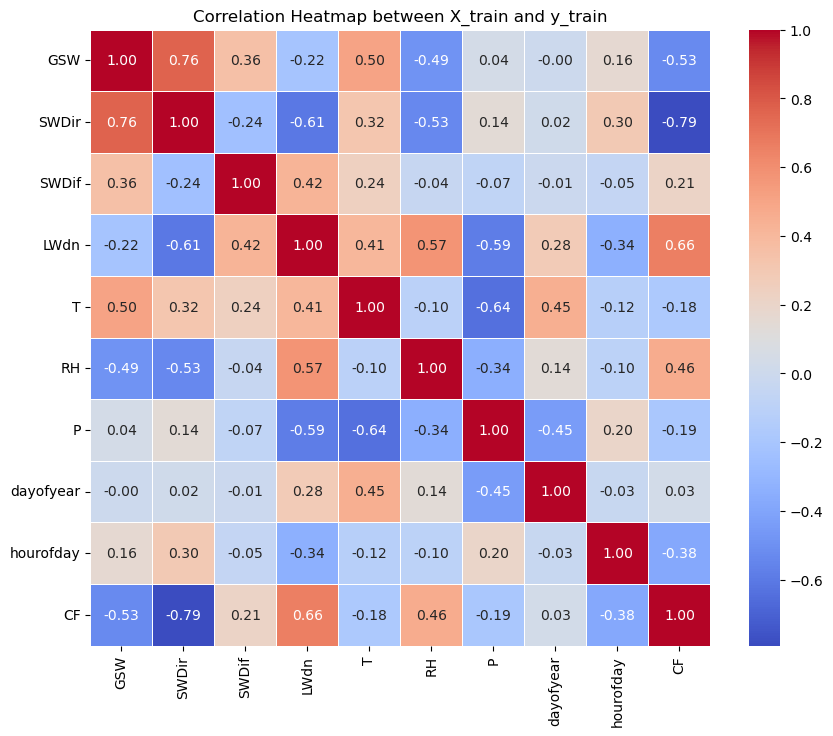

In [4]:
def plot_corr(data: pd.DataFrame, only_value=0):
    # Combine X_train and y_train into a single DataFrame for correlation calculation
    # data = pd.concat([X_train, y_train.rename('Target_CF')], axis=1)

    # Compute the correlation matrix
    correlation_matrix = data.corr()
    print(correlation_matrix[correlation_matrix.index=='CF'])

    if not only_value:

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title("Correlation Heatmap between X_train and y_train")
        plt.show()

df = pd.concat([X_train, y_train.rename('CF')], axis=1)
plot_corr(df)


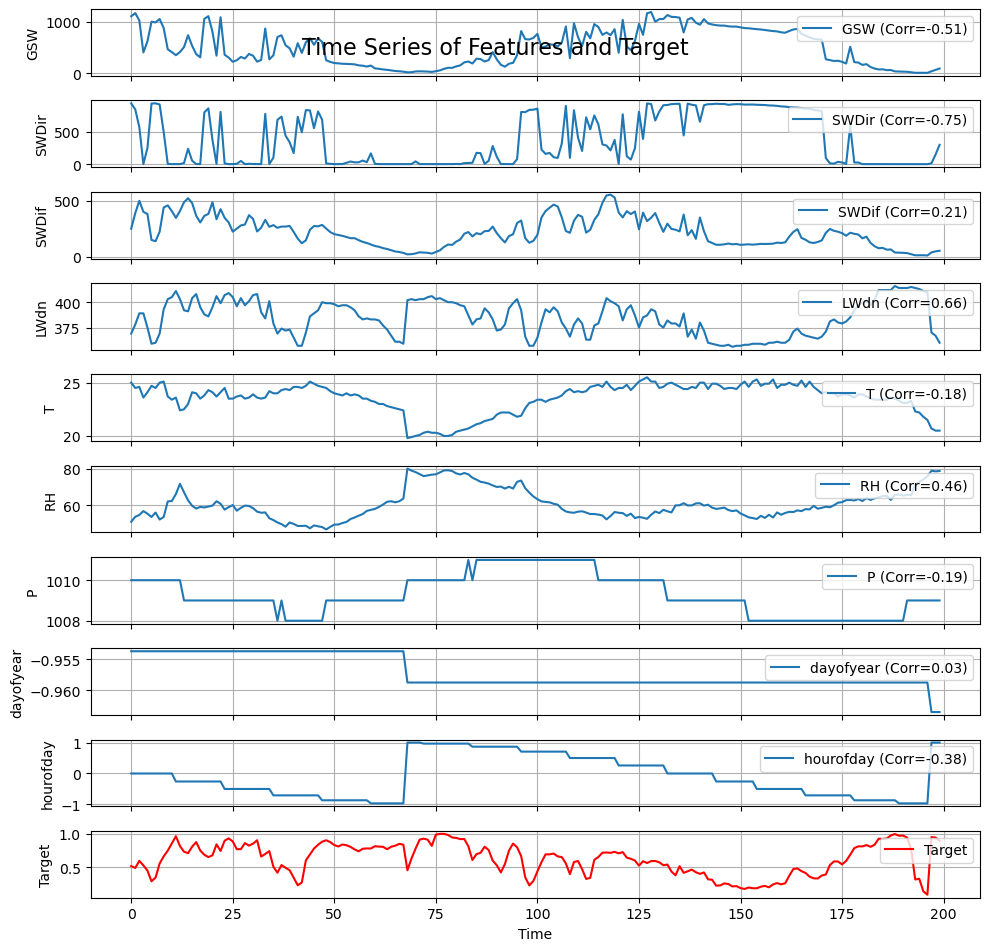

In [48]:
n_point = 200

def show_time_series(n=200, fig_name='time_series.png'):

    # Select the first n_point points
    X_train_subset = X_train.iloc[:n_point]
    y_train_subset = y_train.iloc[:n_point]

    # Compute correlations between features and the target
    correlations = X_train.corrwith(y_train)

    # Set up the plot grid
    n_features = X_train_subset.shape[1]
    fig, axes = plt.subplots(n_features + 1, 1, figsize=(10, 1 * (n_features + 1)), sharex=True)

    # Plot each feature as a separate subplot
    time = np.arange(len(X_train_subset))  # Assuming indices represent time
    for i, column in enumerate(X_train_subset.columns):
        axes[i].plot(time, X_train_subset[column], label=f"{column} (Corr={correlations[column]:.2f})")
        axes[i].legend(loc="upper right")
        axes[i].set_ylabel(column)
        axes[i].grid()

    # Plot the target variable at the bottom
    axes[-1].plot(time, y_train_subset, color='red', label='Target')
    axes[-1].legend(loc="upper right")
    axes[-1].set_ylabel("Target")
    axes[-1].grid()

    # Set common X-axis label and title
    plt.xlabel("Time")
    plt.suptitle("Time Series of Features and Target", y=0.92, fontsize=16)
    plt.tight_layout()
    plt.savefig(fig_name, dpi=200)
    plt.show()

show_time_series(n=300,)

## 3. lag --- 
- radiative feedback: speed of light, 
- thermal feedback of cloud: minutes -> hours 

size of df = 66280


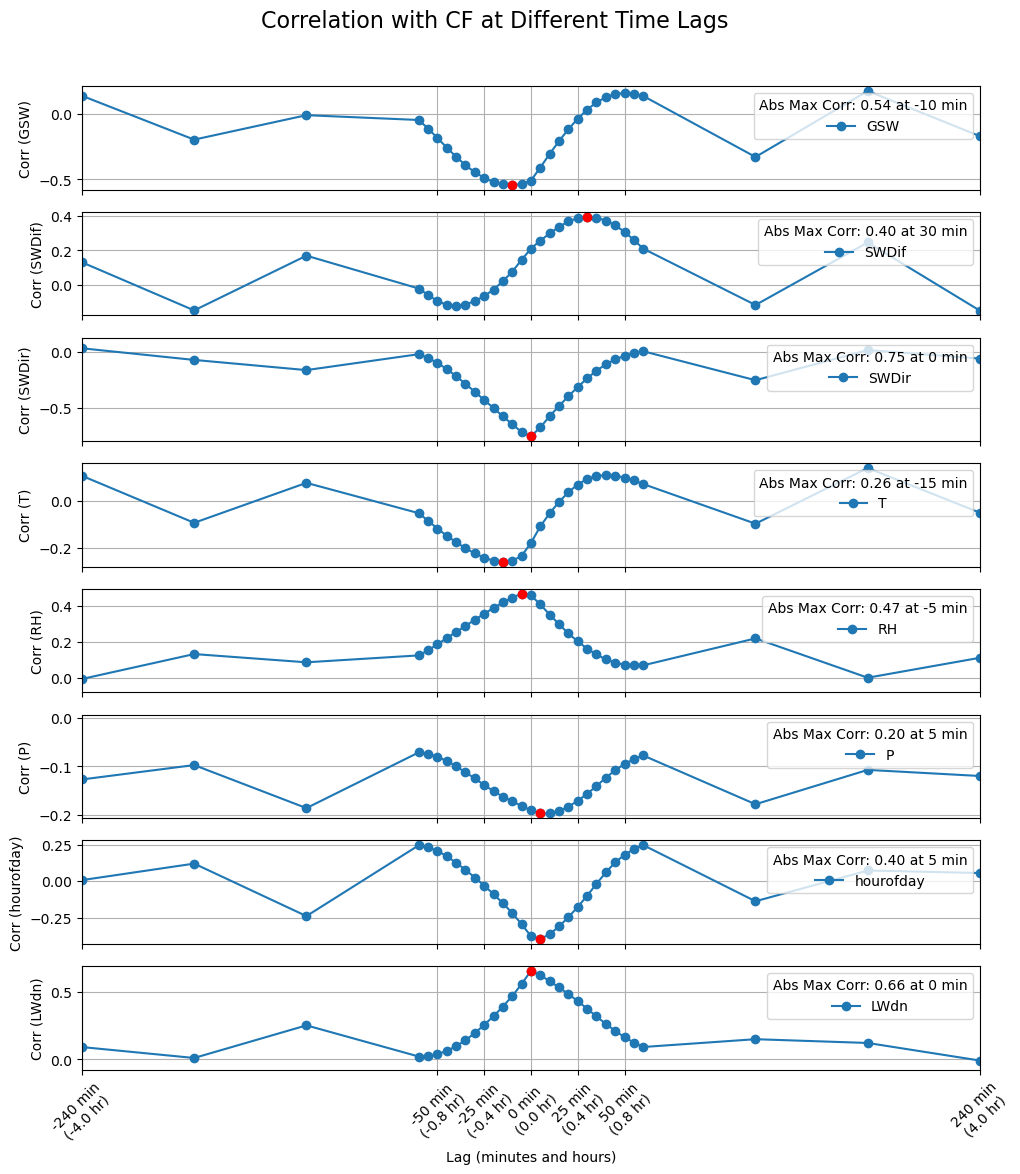

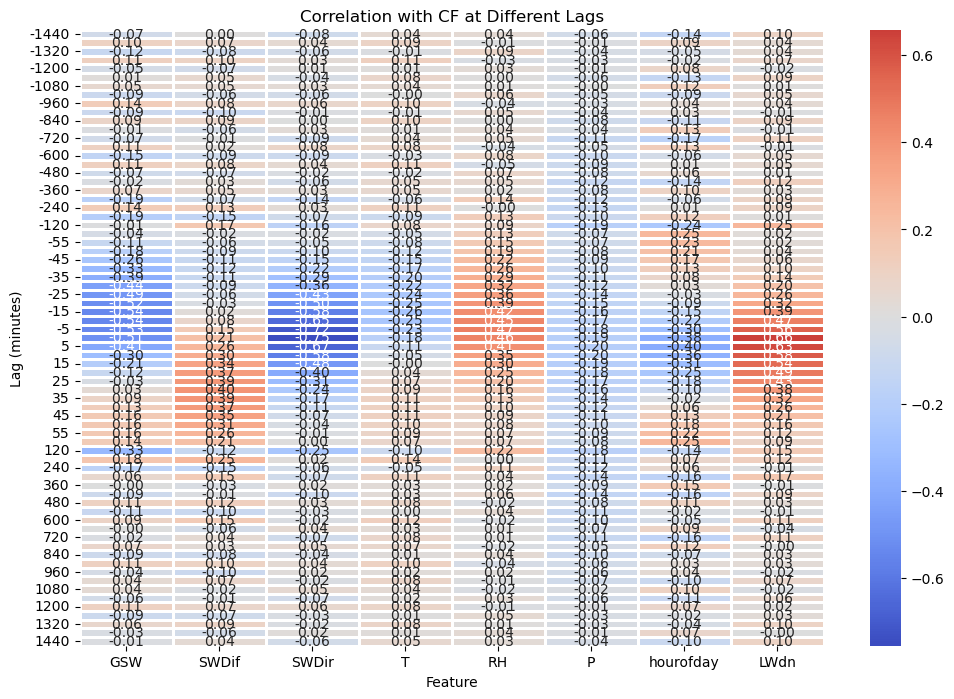

In [49]:
def check_lag_corr(df):

    features_to_compare = ['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn']

    print(f'size of df = {len(df)}')

    # Define the lag lists 
    lag1 = list(range(5, 65, 5))  # 5 to 60 minutes in 5-minute steps
    lag2 = list(range(120, 24*60 + 1, 60))  # 120 to 1440 minutes (24 hours) in 60-minute steps
    lag3 = [x * -1 for x in lag1]  # Negative values of lag1
    lag4 = [x * -1 for x in lag2]  # Negative values of lag2

    # Combine all lags and include 0
    lag5 = lag1 + lag2 + lag3 + lag4 + [0]

    # Sort the lags to have them in ascending order
    lags = sorted(lag5)

    # Initialize a dictionary to store correlations for each feature at each lag
    lagged_correlations = {feature: [] for feature in features_to_compare}

    # Loop through the lags and calculate correlations
    for lag in lags:
        # Shift the target and features by 'lag' steps (in terms of 5-minute intervals)
        df_shifted = df[features_to_compare].shift(lag)
        for feature in features_to_compare:
            corr = df_shifted[feature].corr(df['CF'])
            lagged_correlations[feature].append(corr)

    # Find the absolute max correlation and corresponding lag for each feature
    max_lags = {}
    for feature in features_to_compare:
        # Find the absolute correlation values
        abs_corr = [abs(corr) for corr in lagged_correlations[feature]]
    
        # Find the absolute maximum correlation and the corresponding lag
        max_corr = max(abs_corr)
        max_lag = lags[abs_corr.index(max_corr)]
    
        # Store the max lag for each feature
        max_lags[feature] = max_lag
    max_lags['CF'] = 0


    # Plotting the correlation at different lags for each feature in subplots
    fig, axes = plt.subplots(len(features_to_compare), 1, figsize=(10, 12), sharex=True)
    fig.suptitle('Correlation with CF at Different Time Lags', fontsize=16)

    # Iterate over each feature and plot the correlation
    for i, feature in enumerate(features_to_compare):
        axes[i].plot(lags, lagged_correlations[feature], marker='o', label=feature)

        # Find the absolute max correlation and the corresponding lag
        abs_corr = [abs(corr) for corr in lagged_correlations[feature]]
        max_corr = max(abs_corr)
        max_lag = lags[abs_corr.index(max_corr)]

        # Highlight the absolute max correlation point in red
        axes[i].plot(max_lag, lagged_correlations[feature][abs_corr.index(max_corr)], 'ro')  # 'ro' stands for red circle markers

        # Add the absolute max correlation to the legend
        axes[i].legend(loc='upper right', title=f'Abs Max Corr: {max_corr:.2f} at {max_lag} min')

        axes[i].set_ylabel(f'Corr ({feature})')
        axes[i].grid(True)

    # Reduce the number of x-ticks by selecting only a subset of the lags
    tick_interval = 5  # Choose an interval to reduce the number of x-ticks (e.g., every 5th lag)
    selected_lags = lags[::tick_interval]  # Select every 'tick_interval' lag for the x-ticks

    # Set the x-ticks and format the x-axis labels
    def format_x_labels(lags):
        return [f"{lag} min\n({lag/60:.1f} hr)" for lag in lags]

    plt.xticks(selected_lags, format_x_labels(selected_lags), rotation=45)
    plt.xlabel('Lag (minutes and hours)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the space to fit title
    plt.xlim(-240, 240)
    plt.show()

    # Creating a heatmap of the maximum correlation for each feature at each lag
    max_corr_df = pd.DataFrame(lagged_correlations, index=lags)

    # Plot the heatmap for the correlations at different lags
    plt.figure(figsize=(12, 8))
    sns.heatmap(max_corr_df, annot=True, cmap='coolwarm', center=0, fmt=".2f", linewidths=1)
    plt.title('Correlation with CF at Different Lags')
    plt.xlabel('Feature')
    plt.ylabel('Lag (minutes)')
    plt.show()

    return max_lags

df=pd.concat([X_train, y_train], axis=1)
max_lags = check_lag_corr(df)

<font size=14 color=red> Conclusion (lag):</font>
- SWDir and LWdn respond immediately to cloud cover changes. lag = 0
- T and Rh respond to cloud cover changes later at 5 to 15 minutes, lag < 0
- GSW < 0 and SWDif = 30 ?

In [50]:
print(max_lags)

{'GSW': -10, 'SWDif': 30, 'SWDir': 0, 'T': -15, 'RH': -5, 'P': 5, 'hourofday': 5, 'LWdn': 0, 'CF': 0}


In [51]:
def shift_df(df, max_lags:dict):
    cf = df[['CF']]

    for i in range(len(max_lags) - 1):

        feature = list(max_lags.keys())[i]
        df1 = df[[feature]]

        df2=df1.shift(freq=pd.DateOffset(minutes=max_lags[feature]))
        df3 = pd.concat([df2, cf], axis=1)
        cf = df3.dropna()

        # print(f'{feature}, {max_lags[feature]}' )
        # print(f'{feature}, df={len(df)},  cf={len(cf)}')

    print(f'df={len(df)},  cf={len(cf)}')

    return cf

# lags = max_lags.copy()
# del lags['dayofyear']

train_shift = shift_df(df, max_lags)
valid_shift = shift_df(df=pd.concat([X_valid, y_valid], axis=1), max_lags=max_lags)
test_shift = shift_df(df=pd.concat([X_test, y_test], axis=1), max_lags=max_lags)

features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn' ]

X_train_shifted = train_shift[features_to_keep]

X_valid_shifted = valid_shift[features_to_keep]
X_test_shifted = test_shift[features_to_keep]

y_train_shifted = train_shift[['CF']]
y_valid_shifted = valid_shift[['CF']]
y_test_shifted = test_shift[['CF']]

# path = f'/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud'
# data_set_name = f'{path}/dataset/raw.bsrn_lacy.2019_2022.5min.local_time.shift.csv'

# df_shift.to_csv(data_set_name)


df=66280,  cf=51521
df=16570,  cf=13020
df=33459,  cf=25713


In [58]:
# for verification:
df.loc['2019-09-14 14']
print(X_train.shape)

(66280, 9)


In [57]:
train_shift.loc['2019-09-14 14']
print(train_shift.shape)

(51521, 9)


size of df = 51521


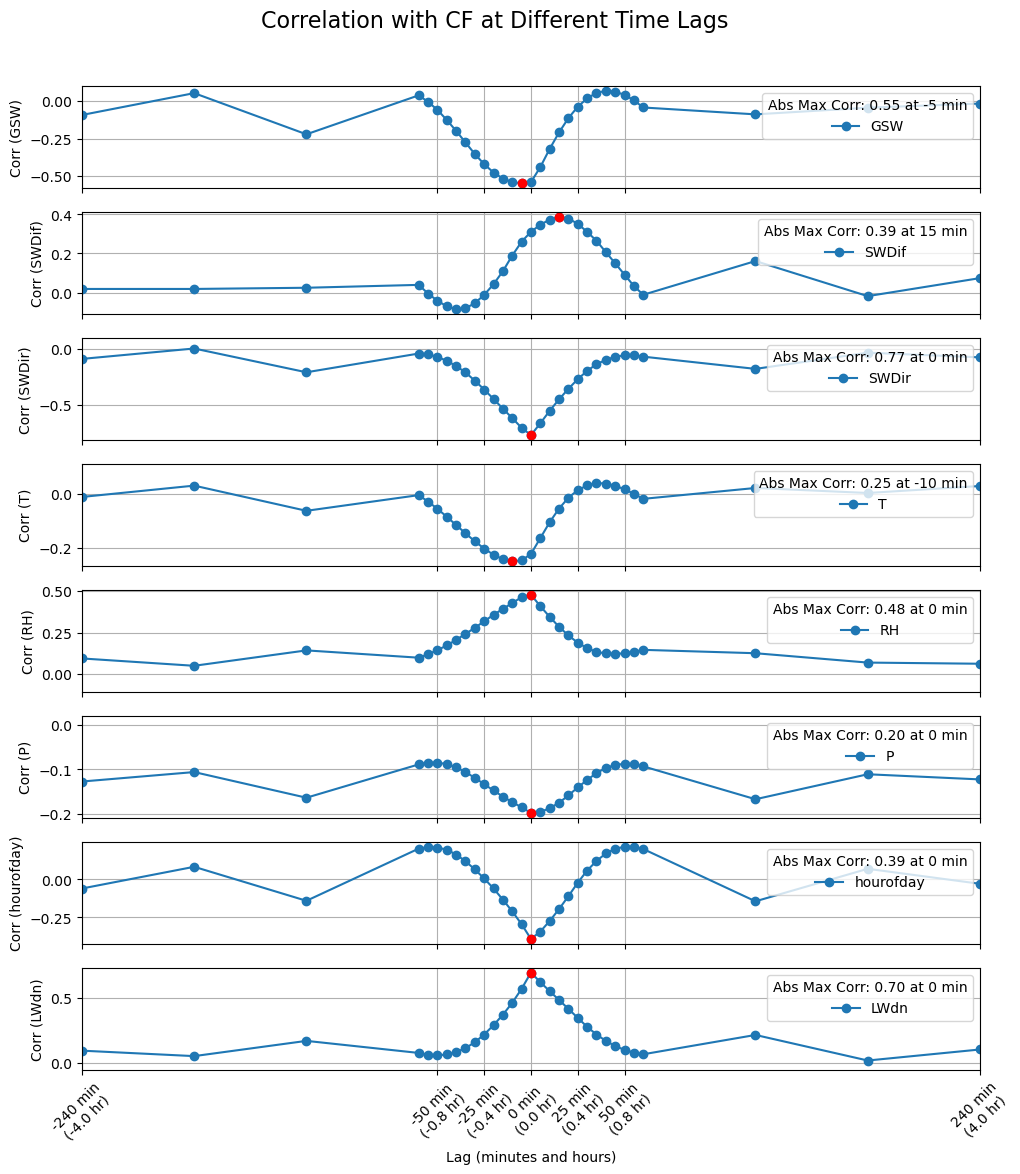

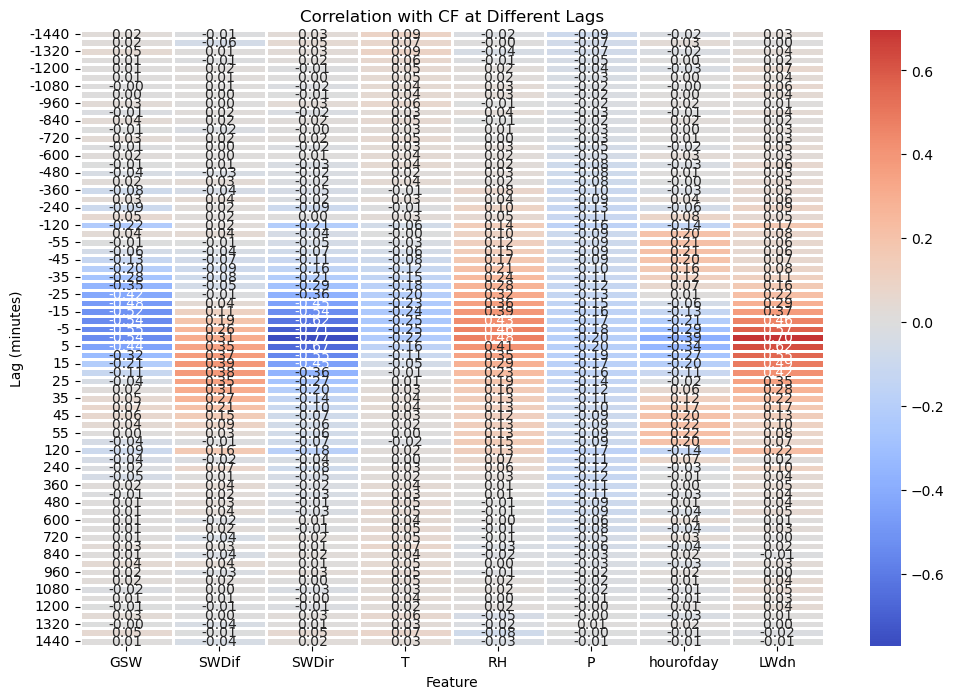

In [54]:
max_lags2 = check_lag_corr(df=train_shift)

In [17]:
print(max_lags, max_lags2, sep='\n')

{'GSW': -10, 'SWDif': 30, 'SWDir': 0, 'T': -15, 'RH': -5, 'P': 5, 'hourofday': 5, 'LWdn': 0, 'CF': 0}
{'GSW': -5, 'SWDif': 15, 'SWDir': 0, 'T': -10, 'RH': 0, 'P': 0, 'hourofday': 0, 'LWdn': 0, 'CF': 0}


<font size=12, color=red> shifted data has a max-corr lag unequal to 0, since data size has been largely reduced. </font>

In [65]:
# compare corr:

plot_corr(df[list(train_shift.columns)], only_value=1)

plot_corr(train_shift, only_value=1)

        LWdn  hourofday         P       RH         T     SWDir     SWDif  \
CF  0.658201  -0.378046 -0.190682  0.45753 -0.177439 -0.754935  0.210623   

         GSW   CF  
CF -0.508402  1.0  
        LWdn  hourofday         P        RH         T     SWDir    SWDif  \
CF  0.697096  -0.392039 -0.197673  0.478446 -0.223498 -0.771297  0.31117   

        GSW   CF  
CF -0.53957  1.0  


<font size=12, color=red> All the correlation are larger now </font>

make a test, then:

In [13]:
from xgboost import XGBRegressor
model = XGBRegressor(
      learning_rate=0.5, n_estimators=200,
      max_depth=5, min_child_weight=3,
      subsample=0.8, colsample_bytree=0.8,
      reg_alpha=0, reg_lambda=0,
      base_score=0.5, booster='gbtree', importance_type='gain',
      interaction_constraints='', validate_parameters=1, verbosity=None)


In [11]:
def feature_elimination(X_train, y_train, X_valid, y_valid, X_test, y_test, features_to_keep, fig_name='elimination.png'):

    # change the order according to the feature importance from default xgboost model, figure in ./XGBoost
    # features_to_keep =['LWdn', 'SWDif', 'SWDir', 'T', 'RH', 'GSW', 'P', 'hourofday', 'dayofyear']
    # features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P',  'hourofday', 'dayofyear']

    # initial variables
    mab, rmse, cor, r_squared = [], [], [], []
    validation_accuracies = []
    train_accuracies = []

    print('N of features: ', end='')
    # Iterate by reducing features
    for i in range(len(features_to_keep), 0, -1):
        print(f'{i}, ', end='')
        # Select features to keep
        selected_features = features_to_keep[:i]
        X_train_reduced = X_train[selected_features]
        X_valid_reduced = X_valid[selected_features]
        X_test_reduced = X_test[selected_features]

        evalSet = [(X_train_reduced, y_train), (X_valid_reduced, y_valid)]

        # print(f'start training...')
        model.fit(X_train_reduced, y_train, verbose=False, eval_set=evalSet)

        scr_train = round(model.score(X_train_reduced, y_train), 4)
        scr_valid = round(model.score(X_valid_reduced, y_valid), 4)

        # plot_learning_curve(model, scr_train, scr_valid, selected_features, fig_name=f'{len(selected_features)}_features.png')

        # statistics calculation :
        y_test_copy = y_test.copy()
        y_test_copy.loc[:, 'CF_pred'] = model.predict(X_test_reduced)

        stats: dict = RESEARCH.calculate_statistics_y_pred_y_test(y_test_copy)

        train_accuracies.append(scr_train)
        validation_accuracies.append(scr_valid)
        mab.append(stats['MAB']),
        rmse.append(stats['RMSE'])
        cor.append(stats['COR'])
        r_squared.append(stats['R_squared'])

    # starts plotting:
    plt.figure(figsize=(10, 6))
    statistics = [mab, rmse, cor, r_squared, train_accuracies, validation_accuracies]
    statistics_labels = ['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
    x = range(len(features_to_keep), 0, -1)
    for j in range(len(statistics)):
        plt.plot(x, statistics[j], label=statistics_labels[j], marker='o')

        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")
        plt.title("Stepwise_Feature_Elimination: Model Performance")
        plt.legend()
    plt.grid()
    plt.ylim([0, 1])
    plt.text(0.15, 0.25, f'{len(features_to_keep)} features in order: {features_to_keep}',
             fontsize=12, color='green', transform=plt.gca().transAxes, verticalalignment='top')
    # Add a text box
    model_params = f'default XGBoost model: \n'\
                   f'learning_rate=0.5, n_estimators=200,\n'\
                   f'max_depth=5, min_child_weight=3,\n'\
                   f'subsample=0.8, colsample_bytree=0.8,'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.45, 0.5, model_params, fontsize=12, color='black', transform=plt.gca().transAxes,
             bbox=props, horizontalalignment='center', verticalalignment='center', wrap=True)

    plt.savefig(fig_name, dpi=220)
    plt.show()

    print(f'the max number of features:')
    print(statistics_labels)
    print([x[0] for x in statistics])

N of features: 8, 7, 6, 5, 4, 3, 2, 1, 

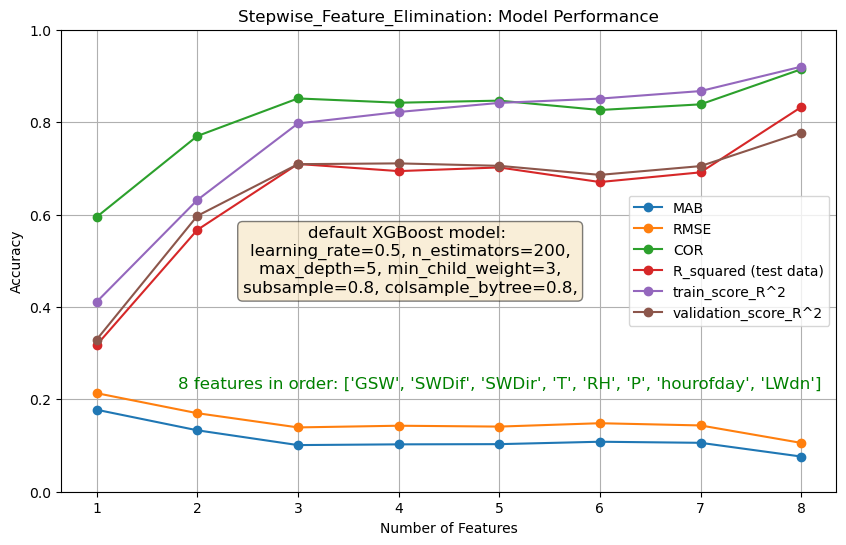

the max number of features:
['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
[0.07614949359322662, 0.10568454064393118, 0.914395750888619, 0.8324952688455374, 0.92, 0.7771]


In [88]:
features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn' ]
feature_elimination(X_train_shifted, y_train_shifted, X_valid_shifted, y_valid_shifted,
                    X_test_shifted, y_test_shifted, features_to_keep=features_to_keep, fig_name='shifted.png')

N of features: 8, 7, 6, 5, 4, 3, 2, 1, 

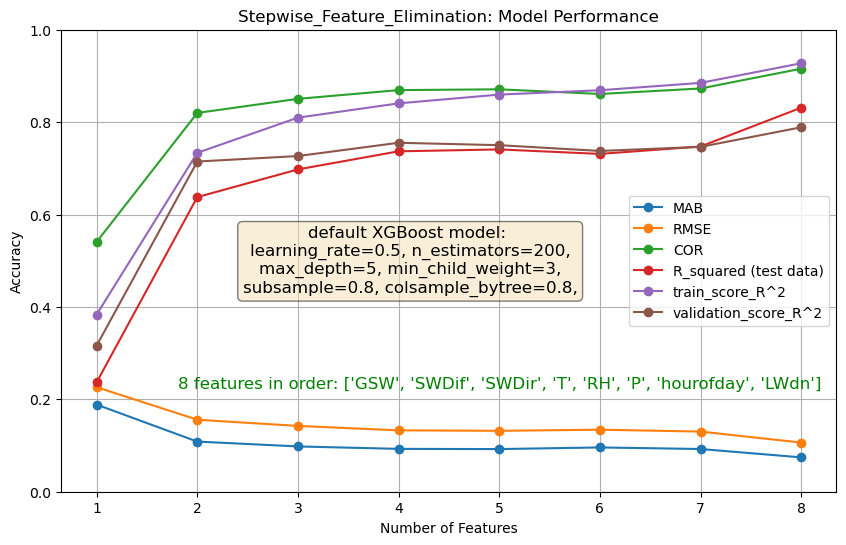

the max number of features:
['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
[0.07434970207554248, 0.1063883458323844, 0.9156611106623149, 0.8312327688348667, 0.9274, 0.7888]


In [ ]:
features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn' ]
feature_elimination(X_train, y_train, X_valid, y_valid,
                    X_test, y_test, features_to_keep=features_to_keep, fig_name='no_shift.png')

### Conclusion:

<font size="5" color="red">shifting orginal data do not helps.</font>

MAB and corr increases by 0.001, validation_score_R^2 decrease by 0.01

probaly due to the reduced data size.

## 4. include 10 minutes before

In [3]:
# generate 10-min mean data

produce_data = 0

if produce_data:
    # ============================= read data ===========================
    path = f'/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud'
    data_set_name = f'{path}/dataset/raw.bsrn_lacy.2019_2022.1min.local_time.csv'
    df_raw_1min = GEO_PLOT.read_csv_into_df_with_header(data_set_name)

    df_10m_mean = RESEARCH.get_mean_by_interval(df_raw_1min, interval='10min', min_point_inside_interval=5)

    csv_name = f'{path}/dataset/raw.bsrn_lacy.2019_2022.10min-mean.local_time.csv'

    df_10m_mean.to_csv(csv_name)

    print(df_10m_mean.head(), df_10m_mean.shape)


<font size=12, color=red> Attention: data size is largely reduced </font>

# 4.1 get data splited by train, valid, test

In [3]:
with_time = 1
shuffle=False

path = f'/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud'
data_name = f'{path}/dataset/raw.bsrn_lacy.2019_2022.10min-mean.local_time.csv'

df_10m_mean = GEO_PLOT.read_csv_into_df_with_header(data_name)

X_train, y_train, X_valid, y_valid, X_test, y_test, \
    X_train_scaled, X_valid_scaled, X_test_scaled, evalSet, df_raw = \
        RESEARCH.prepare_data(df_raw=df_10m_mean, train_valid_rate=0.2, with_time=with_time, shuffle=shuffle)
print(X_train.head())
print(X_train.shape, X_valid.shape, X_test.shape)

Index(['GSW', 'SWDir', 'SWDif', 'LWdn', 'T', 'RH', 'P', 'dayofyear',
       'hourofday'],
      dtype='object')
                             GSW       SWDir       SWDif        LWdn  \
DateTimeIndex                                                          
2019-09-13 12:10:00  1031.714286  793.428571  311.571429  372.428571   
2019-09-13 12:20:00   825.200000  419.500000  444.400000  387.800000   
2019-09-13 12:30:00   789.400000  508.900000  322.300000  372.900000   
2019-09-13 12:40:00   995.700000  931.400000  157.100000  361.000000   
2019-09-13 12:50:00   796.500000  441.000000  402.300000  391.900000   

                             T         RH       P  dayofyear     hourofday  
DateTimeIndex                                                               
2019-09-13 12:10:00  24.928571  51.885714  1010.0  -0.953681  1.224647e-16  
2019-09-13 12:20:00  24.310000  55.370000  1010.0  -0.953681  1.224647e-16  
2019-09-13 12:30:00  24.090000  55.500000  1010.0  -0.953681  1.224647e-16 

## 4.2 correlation


In [6]:
print(f'5-min instantanous')
plot_corr(pd.concat([X_train, y_train.rename('CF')], axis=1), only_value=1)

print(f'10-min mean')
plot_corr(df_10m_mean, only_value=1)

5-min instantanous
         GSW    SWDir     SWDif      LWdn         T        RH         P  \
CF -0.529183 -0.79163  0.214445  0.660585 -0.179363  0.463078 -0.192039   

    dayofyear  hourofday   CF  
CF   0.028682  -0.380676  1.0  
10-min mean
         GSW    SWDir     SWDif      LWdn         T        RH         P   CF  \
CF -0.498206 -0.77518  0.266991  0.700919 -0.094866  0.491538 -0.254056  1.0   

    dayofyear  hourofday  
CF   0.083708  -0.327033  


<font size=12, color=red> conclusion, only SWDif, LWdn, RH, P, dayofyear corr increased.</font>

N of features: 8, 7, 6, 5, 4, 3, 2, 1, 

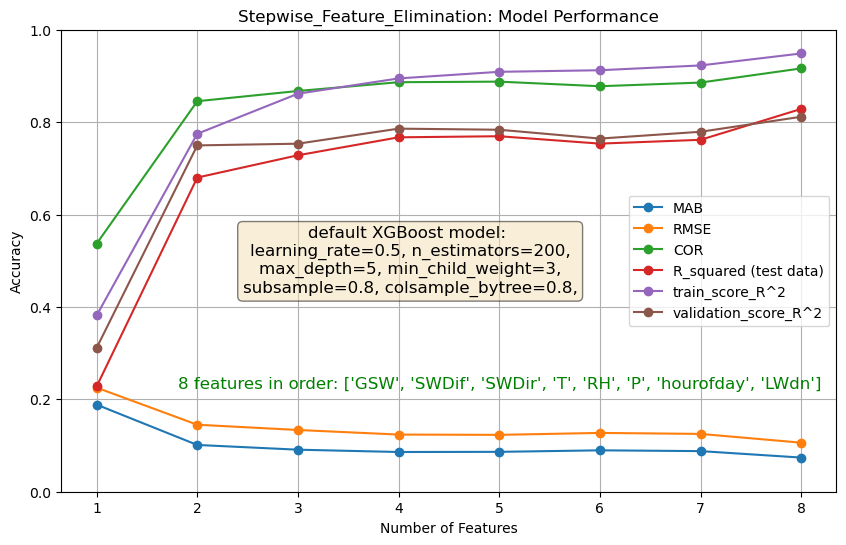

the max number of features:
['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
[0.07391665631393807, 0.10614993188368273, 0.9162380015436823, 0.8285354663503, 0.9486, 0.8116]


In [14]:
features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn' ]
feature_elimination(X_train, y_train, X_valid, y_valid,
                    X_test, y_test, features_to_keep=features_to_keep, fig_name='10-min_mean.png')

<font size=12, color=red> conclusion of averaging at 10 minute, on help</font>

- slightly better trainning and validation score
- MAB, RMSE, COR and R_squared change very little.

# 5 using 5 minute before and after the prediction time of CF

this will increase the size of predictors.

if using 5 minute data, it will be 3 times larger.

In [43]:
def resample_before_after(df, interval='5min'):
    # Resample at every 5 minutes starting at 0, 5, 10, ..., 55 minutes of each hour
    resampled_df = df.resample(interval).mean()
    
    # Create shifted versions: 5 minutes before and after
    shifted_before = resampled_df.shift(1, freq=interval)
    shifted_after = resampled_df.shift(-1, freq=interval)

    # Combine columns with '_before', original, and '_after' suffixes
    combined_df = pd.DataFrame(index=resampled_df.index)
    for col in df.columns:
        combined_df[f"{col}_before"] = shifted_before[col]
        combined_df[f"{col}"] = resampled_df[col]
        combined_df[f"{col}_after"] = shifted_after[col]

    # Identify rows where the time difference exceeds 5 minutes for before or after
    mask_valid_before = (resampled_df.index - shifted_before.index.to_series()).abs() <= pd.Timedelta(minutes=5)
    mask_valid_after = (shifted_after.index.to_series() - resampled_df.index).abs() <= pd.Timedelta(minutes=5)

    # Only keep rows where both before and after are within 5 minutes
    valid_mask = mask_valid_before & mask_valid_after
    final_df = combined_df[valid_mask].drop(['CF_before', 'CF_after'], axis=1).dropna()

    return final_df


In [44]:
path = f'/Users/ctang/Microsoft_OneDrive/OneDrive/CODE/LW_XGBoost_Cloud'
data_set_name = f'{path}/dataset/raw.bsrn_lacy.2019_2022.1min.local_time.csv'
df_raw_1min = GEO_PLOT.read_csv_into_df_with_header(data_set_name)

df_resampled_5min= resample_before_after(df_raw_1min, interval='5min')


/var/folders/5l/kfstrwgj10102hslf3251mmm0000gn/T/ipykernel_90167/2790459544.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_df = combined_df[valid_mask].drop(['CF_before', 'CF_after'], axis=1).dropna()


N of features: 8, 7, 6, 5, 4, 3, 2, 1, 

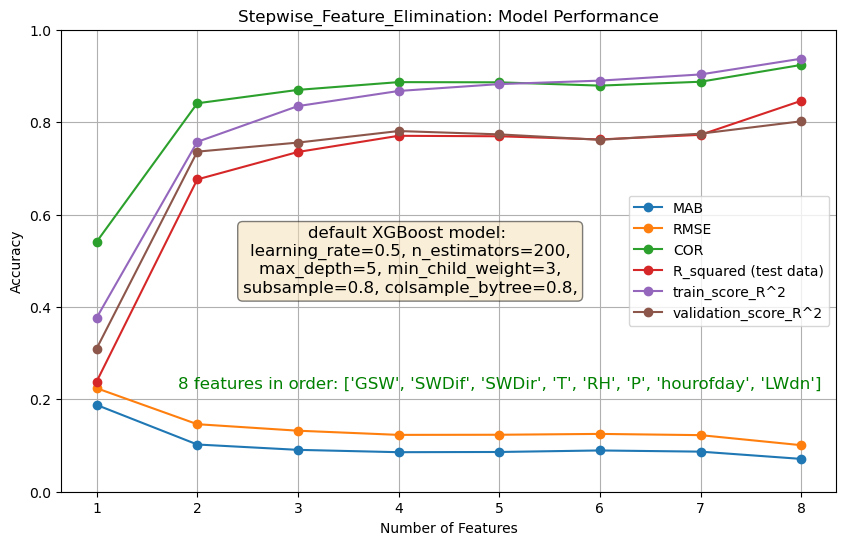

the max number of features:
['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
[0.07105148226948915, 0.10073534246436532, 0.9238173271203933, 0.8460814547089323, 0.9373, 0.8018]


In [45]:

features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'LWdn' ]
feature_elimination(X_train, y_train, X_valid, y_valid,
                    X_test, y_test, features_to_keep=features_to_keep, fig_name='10-min_mean.png')

['GSW_before', 'GSW', 'GSW_after', 'SWDir_before', 'SWDir', 'SWDir_after', 'SWDif_before', 'SWDif', 'SWDif_after', 'LWdn_before', 'LWdn', 'LWdn_after', 'T_before', 'T', 'T_after', 'RH_before', 'RH', 'RH_after', 'P_before', 'P', 'P_after']
N of features: 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 

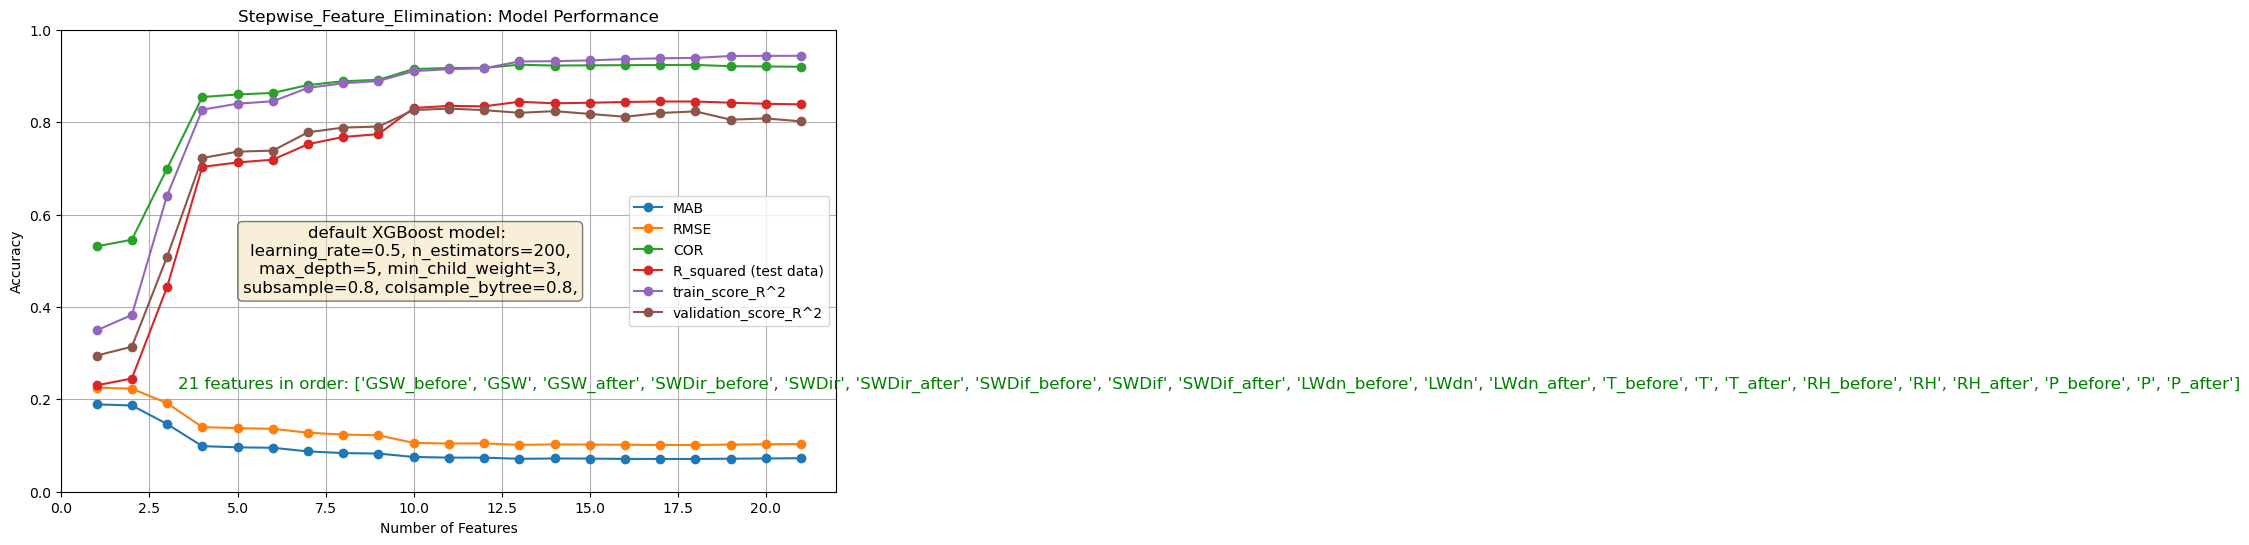

the max number of features:
['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
[0.07253637313762248, 0.1031895816774552, 0.9197918389936204, 0.8384901850998299, 0.9435, 0.8017]


In [46]:
features_to_keep = df_resampled_5min.columns.tolist()
features_to_keep.remove('CF')
print(features_to_keep)

feature_elimination(X_train, y_train, X_valid, y_valid,
                    X_test, y_test, features_to_keep=features_to_keep, fig_name='3min_before_after.png')

## 3. Application de l'ACP pour réduire le nombre de caractéristique
L’analyse en composantes principales permet de réduire la dimension du nombre de caractéristique utilisées pour la classification (effectuée sur un nombre réduit de composantes principales). Le nombre de composantes principales utilisées comme caractéristiques dépend du pourcentage de la variance totale expliquée par chaque composante principale.

### 3.1 ACP des données d'entrées

##### (a) Effectuer une ACP des données d'entrées d'apprentissage X_train et  appliquer cette ACP aux  données d'entrées X_test.

On notera X_train_ACP et X_test_ACP les entrées obtenues après l'ACP.

In [ ]:
from sklearn.decomposition import PCA

# ACP
model_ACP = PCA()
X_pca_train = model_ACP.fit_transform(X_train)
X_pca_valid = model_ACP.fit_transform(X_valid)
X_pca_test = model_ACP.transform(X_test)

print(X_pca_test.shape, y_test.shape)


(33459, 9) (33459, 2)


##### (b) Visualiser les 2 premières composantes

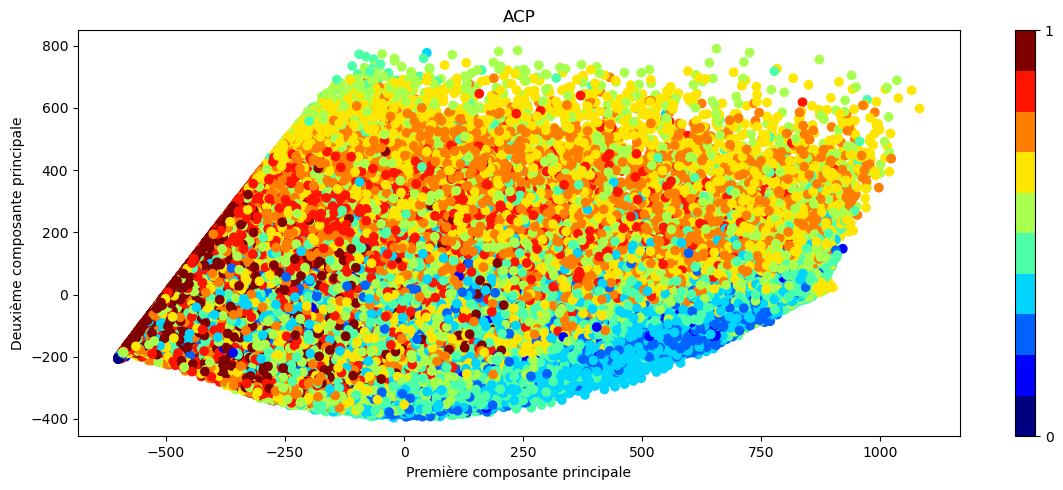

In [57]:
# Visualisation des 2 premières composantes
plt.figure(figsize=(12, 5))


plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, cmap=plt.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.title('ACP')
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')

plt.tight_layout()
plt.show()

### 3.2 Visualisation du pourcentage de variance expliqué par chaque composante

##### (a) Calculer et visualiser le pourcentage de variance expliquée par chaque composante.

Text(0.5, 1.0, 'Variance expliquée')

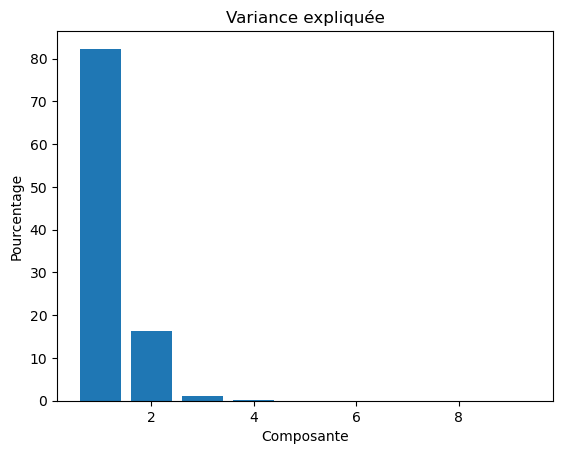

In [58]:
#------------- Calcul du pourcentage de variance expliquée par chaque composante-----------------
variance=model_ACP.explained_variance_ratio_
variance=variance*100

#------------- Visualisation graphique de la variance expliquée par chaque composante-----------------
plt.figure()
plt.bar(range(1,len(variance)+1),variance)  # tracer du graphe
plt.xlabel('Composante')  # titre sur l'axe des abcisses
plt.ylabel('Pourcentage')  # titre sur l'axe des ordonnés
plt.title('Variance expliquée')  # ajout d'un titre


##### (b) Calculer et visualiser le pourcentage de la variance expliquée cumulée.


Pourcentage de variance cumulée est : [ 82.34  98.64  99.82  99.98 100.   100.   100.   100.   100.  ] %


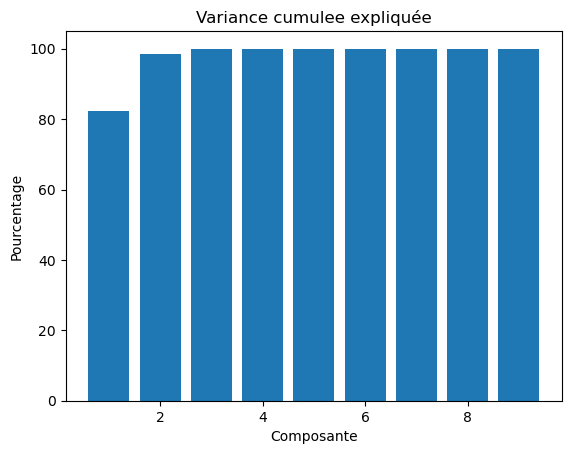

In [59]:
#------------- Calcul de la variance expliquée cumulée-----------------
variance_cumulee = np.cumsum(variance)


#------------- Visualisation graphique de la variance expliquée cumulée -----------------
plt.figure()
plt.bar(range(1,len(variance_cumulee)+1),variance_cumulee) # tracer du graphe
plt.xlabel('Composante')  # titre sur l'axe des abcisses
plt.ylabel('Pourcentage')  # titre sur l'axe des ordonnés
plt.title('Variance cumulee expliquée')  # ajout d'un titre

#------------- Afficher le pourcentage de variance expliquée cumulée (garder 2 chiffres après la virgule)
print('\nPourcentage de variance cumulée est :', variance_cumulee.round(2),'%')

### 3.3 Réduction du nombre de caractéristiques utililisées pour la classification

A partir des résultats précendents, conserver uniquement les composantes nécessaire afin de préserver plus 80% de l'information. On notera X_train_reduit et X_test_reduit les résultats obtenus.

### 3.4 test with different number of feature 

In [60]:
from xgboost import XGBRegressor
model = XGBRegressor(
      learning_rate=0.5, n_estimators=200,
      max_depth=5, min_child_weight=3,
      subsample=0.8, colsample_bytree=0.8,
      reg_alpha=0, reg_lambda=0,
      base_score=0.5, booster='gbtree', importance_type='gain',
      interaction_constraints='', validate_parameters=1, verbosity=None)


In [16]:
# test from 1 to 7 components:
# -----------------------------------------------------------------------

def pca_test(X_pca_train, X_pca_valid, X_pca_test, fig_name='pca_test.png'):

    total_component = X_pca_train.shape[1]

    feature_names = [f'component_{i}' for i in range(1, total_component+1)]

    # initial variables

    mab, rmse, cor, r_squared = [], [], [], []
    validation_accuracies = []
    train_accuracies = []

    print('N of features: ', end='')
    # Iterate by reducing features
    for i in range(1,total_component+1):
        print(f'{i}, ', end='')

        X_train_reduced = X_pca_train[:,:i]
        X_valid_reduced = X_pca_valid[:,:i]
        X_test_reduced = X_pca_test[:,:i]

        # print("reduced:", X_pca_test.shape, y_test.shape, X_test_reduced.shape)

        evalSet = [(X_train_reduced, y_train), (X_valid_reduced, y_valid)]

        # print(f'start training...')
        # print(X_train_reduced.shape, y_train.shape)

        model.fit(X_train_reduced, y_train, verbose=False, eval_set=evalSet)

        scr_train = round(model.score(X_train_reduced, y_train), 4)
        scr_valid = round(model.score(X_valid_reduced, y_valid), 4)

        # plot_learning_curve(model, scr_train, scr_valid, ['pca'], fig_name=f'{X_train_reduced.shape[1]}_features.png')

        y_test['CF_pred'] = model.predict(X_test_reduced)

        stats: dict = RESEARCH.calculate_statistics_y_pred_y_test(y_test)

        train_accuracies.append(scr_train)
        validation_accuracies.append(scr_valid)
        mab.append(stats['MAB'])
        rmse.append(stats['RMSE'])
        cor.append(stats['COR'])
        r_squared.append(stats['R_squared'])

    # ------------------------------ plot
    plt.figure(figsize=(10, 6))
    
    statistics = [mab, rmse, cor, r_squared, train_accuracies, validation_accuracies]
    statistics_labels = ['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
    
    x = range(1, total_component + 1)
    
    for i in range(len(statistics)):
        plt.plot(x, statistics[i], label=statistics_labels[i], marker='o')
        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")
        plt.title("PCA: Model Performance")
        plt.legend()
    
    plt.grid()
    plt.ylim([0, 1])
    
    # Add a text box
    
    model_params = f'default XGBoost model: \n'\
                   f'learning_rate=0.5, n_estimators=200,\n'\
                   f'max_depth=5, min_child_weight=3,\n'\
                   f'subsample=0.8, colsample_bytree=0.8,'
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    plt.text(0.45, 0.5, model_params, fontsize=12, color='black', transform=plt.gca().transAxes,
             bbox=props, horizontalalignment='center', verticalalignment='center', wrap=True)
    
    plt.savefig(fig_name, dpi=220)
    plt.show()

In [36]:
def feature_elimination(features_to_keep, fig_name='elimination.png'):

    # change the order according to the feature importance from default xgboost model, figure in ./XGBoost
    # features_to_keep =['LWdn', 'SWDif', 'SWDir', 'T', 'RH', 'GSW', 'P', 'hourofday', 'dayofyear']
    # features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P',  'hourofday', 'dayofyear']

    # initial variables
    mab, rmse, cor, r_squared = [], [], [], []
    validation_accuracies = []
    train_accuracies = []

    print('N of features: ', end='')
    # Iterate by reducing features
    for i in range(len(features_to_keep), 0, -1):
        print(f'{i}, ', end='')
        # Select features to keep
        selected_features = features_to_keep[:i]
        X_train_reduced = X_train[selected_features]
        X_valid_reduced = X_valid[selected_features]
        X_test_reduced = X_test[selected_features]

        evalSet = [(X_train_reduced, y_train), (X_valid_reduced, y_valid)]

        # print(f'start training...')
        model.fit(X_train_reduced, y_train, verbose=False, eval_set=evalSet)

        scr_train = round(model.score(X_train_reduced, y_train), 4)
        scr_valid = round(model.score(X_valid_reduced, y_valid), 4)

        # plot_learning_curve(model, scr_train, scr_valid, selected_features, fig_name=f'{len(selected_features)}_features.png')

        #
        y_test['CF_pred'] = model.predict(X_test_reduced)

        stats: dict = RESEARCH.calculate_statistics_y_pred_y_test(y_test)

        train_accuracies.append(scr_train)
        validation_accuracies.append(scr_valid)
        mab.append(stats['MAB']),
        rmse.append(stats['RMSE'])
        cor.append(stats['COR'])
        r_squared.append(stats['R_squared'])

    plt.figure(figsize=(10, 6))
    statistics = [mab, rmse, cor, r_squared, train_accuracies, validation_accuracies]
    statistics_labels = ['MAB', 'RMSE', 'COR', 'R_squared (test data)', 'train_score_R^2', 'validation_score_R^2']
    x = range(len(features_to_keep), 0, -1)
    for i in range(len(statistics)):
        plt.plot(x, statistics[i], label=statistics_labels[i], marker='o')

        plt.xlabel("Number of Features")
        plt.ylabel("Accuracy")
        plt.title("Stepwise_Feature_Elimination: Model Performance")
        plt.legend()
    plt.grid()
    plt.ylim([0, 1])
    plt.text(0.15, 0.25, f'{len(features_to_keep)} features in order: {features_to_keep}',
             fontsize=12, color='green', transform=plt.gca().transAxes, verticalalignment='top')
    # Add a text box
    model_params = f'default XGBoost model: \n'\
                   f'learning_rate=0.5, n_estimators=200,\n'\
                   f'max_depth=5, min_child_weight=3,\n'\
                   f'subsample=0.8, colsample_bytree=0.8,'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.45, 0.5, model_params, fontsize=12, color='black', transform=plt.gca().transAxes,
             bbox=props, horizontalalignment='center', verticalalignment='center', wrap=True)

    plt.savefig(fig_name, dpi=220)
    plt.show()


N of features: 9, 8, 7, 6, 5, 4, 3, 2, 1, 

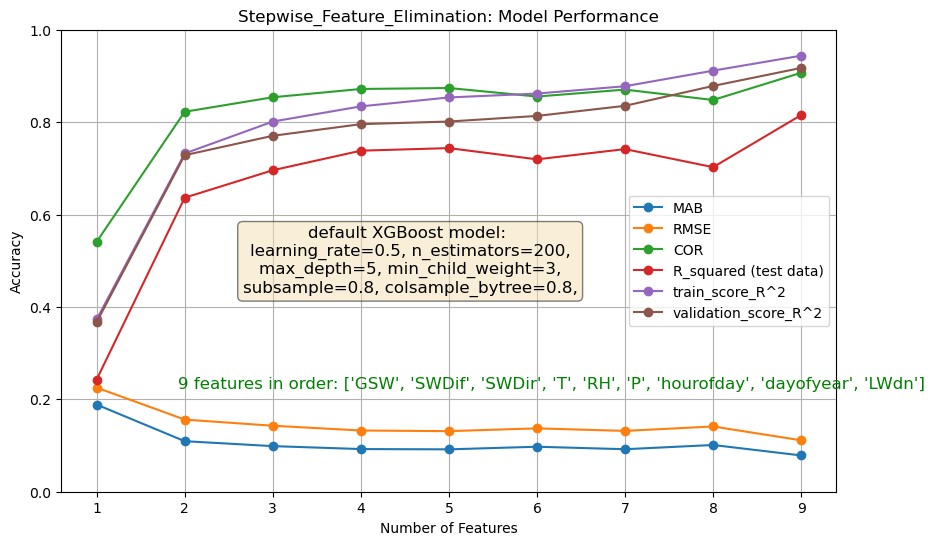

N of features: 9, 8, 7, 6, 5, 4, 3, 2, 1, 

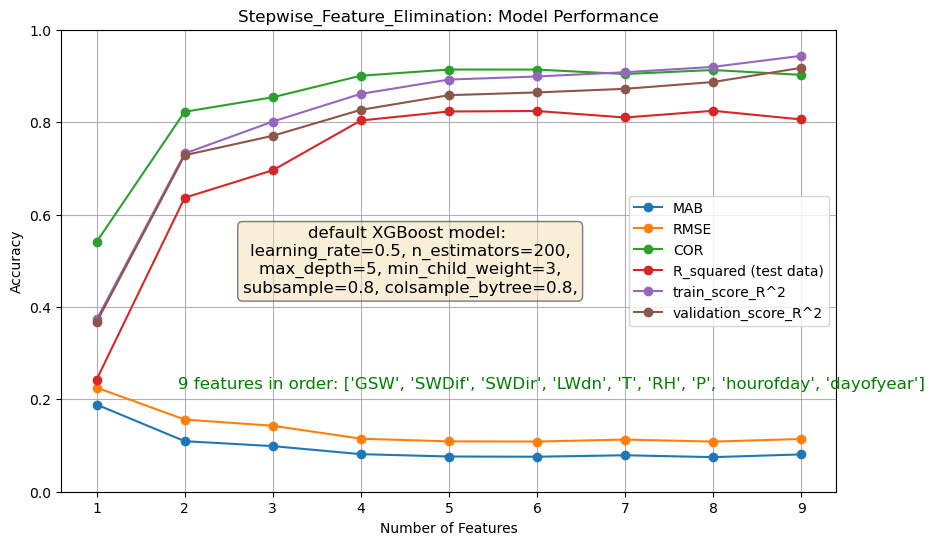

N of features: 9, 8, 7, 6, 5, 4, 3, 2, 1, 

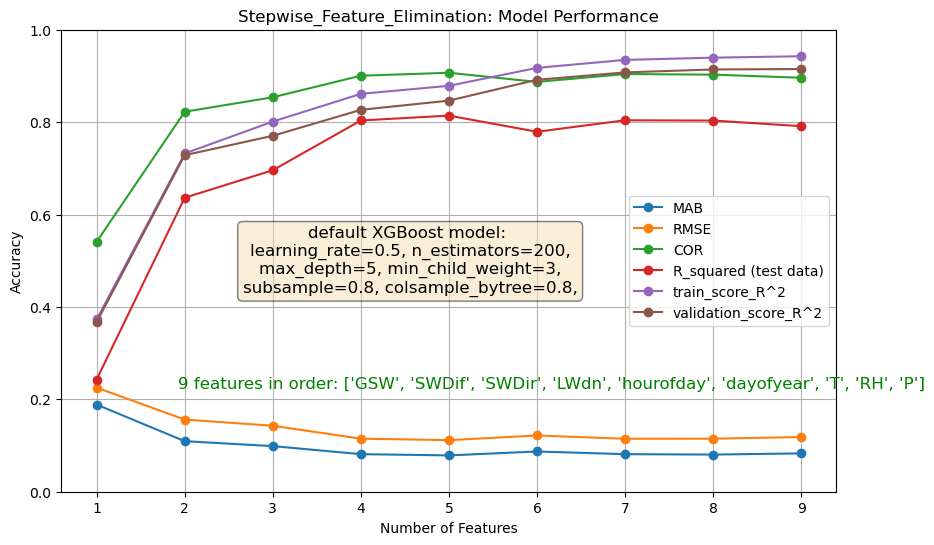

In [54]:
features_to_keep =['GSW', 'SWDif', 'SWDir', 'T', 'RH', 'P', 'hourofday', 'dayofyear', 'LWdn' ]
feature_elimination(features_to_keep=features_to_keep, fig_name='feature_elimination.9.png')

features_to_keep =['GSW', 'SWDif', 'SWDir', 'LWdn', 'T', 'RH', 'P', 'hourofday', 'dayofyear', ]
feature_elimination(features_to_keep=features_to_keep, fig_name='feature_elimination.9.png')

features_to_keep =['GSW', 'SWDif', 'SWDir', 'LWdn', 'hourofday', 'dayofyear', 'T', 'RH', 'P',]
feature_elimination(features_to_keep=features_to_keep, fig_name='feature_elimination.9.png')

N of features: 1, 2, 3, 4, 5, 6, 7, 8, 9, 

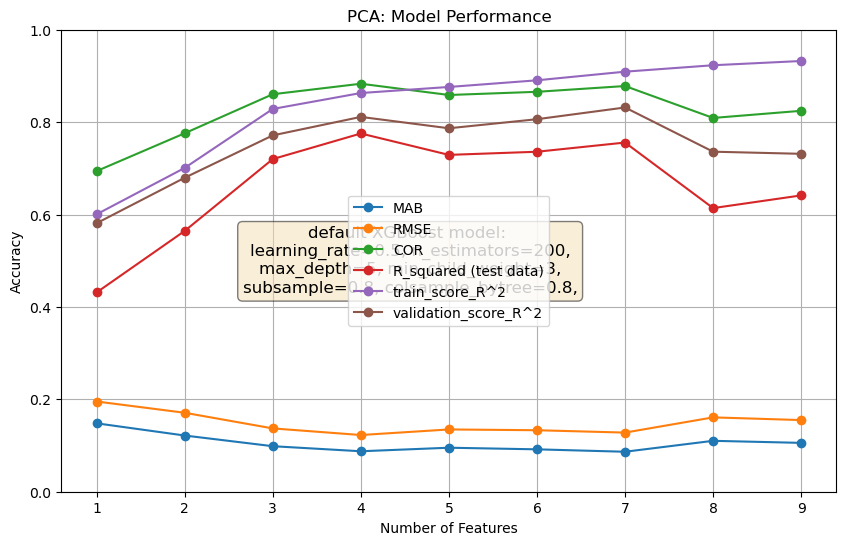

In [61]:
pca_test(X_pca_train=X_pca_train, X_pca_valid=X_pca_valid, X_pca_test=X_pca_test, fig_name='pca_test.png')


## 3BIS. Application de kernel ACP pour réduire le nombre de caractéristique

### 3.1BIS KACP des données d'entrées

kACP des données d'entrées

Déterminer la bibliothèque, les instructions et les structures requises :
- pour effectuer une kACP des données d'entrées d'apprentissage X_train,
- et pour appliquer cette kACP aux  données d'entrées X_test.

On notera X_train_kACP et X_test_kACP les entrées obtenues après l'kACP. **On utilisera un kernel cosine.**

In [15]:
# from sklearn.decomposition import KernelPCA

# n_component = 5

# # kACP
# #On conserve n_component composante comme pour ACP
# kernel_pca = KernelPCA(n_components=n_component,kernel="cosine") 

# X_kpca_train = kernel_pca.fit_transform(X_train)
# X_kpca_train = kernel_pca.fit_transform(X_valid)
# X_kpca_test = kernel_pca.transform(X_test)


In [16]:
# # Visualisation des 2 premières composantes
# plt.figure(figsize=(12, 5))

# plt.scatter(X_kpca_train[:, 0], X_kpca_train[:, 1], c=y_train, cmap=plt.cm.get_cmap('jet', 10))
# plt.colorbar(ticks=range(10))
# plt.title('kPCA cosine')
# plt.xlabel('Première composante principale')
# plt.ylabel('Deuxième composante principale')

# plt.tight_layout()
# plt.show()

In [17]:
# test kPCA result with XGBoost model:
# pca_test(X_pca_train=X_pca_train, X_pca_valid=X_pca_valid, X_pca_test=X_pca_valid, fig_name='pca_test.png')

Remarque : On fait un peu mieux qu'avec ACP mais on a toujours 13 composantes

## 4. Application de UMAP (Uniform manifold approximation and projection for dimension reduction) pour réduire le nombre de caractéristique

### 4.1 UMAP des données d'entrées

Déterminer la bibliothèque, les instructions et les structures requises :
- pour effectuer UMAP des données d'entrées d'apprentissage X_train pour réduire le nombre de caractéristiques à 2,
- et pour appliquer UMAP aux  données d'entrées X_test.

On notera X_train_umap et X_test_umap les entrées obtenues après UMAP.

In [62]:
# UMAP alternative plus récente à t-sne

#INSTALLATION 
# Dans un terminal : 
# !pip install umap-learn

from umap import UMAP

n_component = 5

umap = UMAP(n_components=n_component, random_state=42, n_jobs=1)
# where n_jobs is for for parallelism, default is 1. this will be overwrite if setting a random seed.

X_umap_train = umap.fit_transform(X_train)
X_umap_valid = umap.transform(X_valid)
X_umap_test = umap.transform(X_test)


##### (b) Visualiser les 2 premières composantes

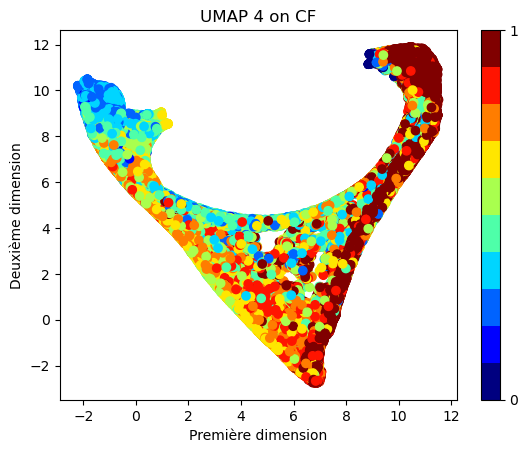

In [47]:
# visulation des 2 premières composantes
plt.scatter(X_umap_train[:, 0], X_umap_train[:, 1], c=y_train, cmap=plt.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.title(f'UMAP {n_component} on CF')
plt.xlabel('Première dimension')
plt.ylabel('Deuxième dimension')
plt.savefig(f'umap_component_{n_component}.png', dpi=220)

#### Remarque
On observe que UMAP sépare les différentes classes ?

#### 4.1.1  Identification d'un modèle XGBoost en utilisant  un nombre réduit de caractéristiques

Aanalyser en détail les résultats obtenus en apprentissage et en validation.
Utiliser les **matrices de confusion.**

**Commenter les résultats obtenus**.

N of features: 1, 2, 3, 4, 

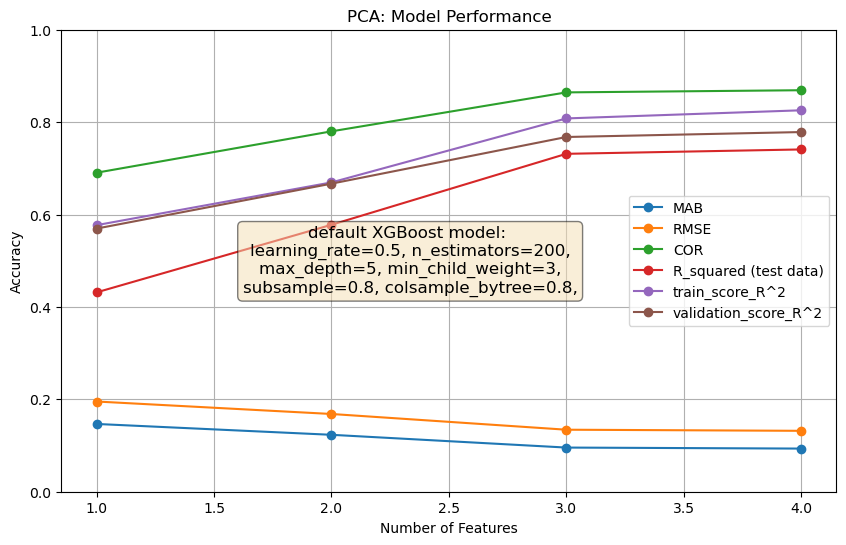

In [52]:
pca_test(X_pca_train=X_umap_train, X_pca_valid=X_umap_valid, X_pca_test=X_umap_test, fig_name=f'umap_test.{n_component}.png')

### REMARQUE

- LWdn is important to increase R_squared from 0.7 to 0.8, better generation skill.
- add hourofday helps
- add dayofyear does NOT helps.
- PCA reduce dimension from 9 to 4. while R_squared reduced to 7.5
- umap, 4 components do not helps
- 

Stephens, G. L., et al. (2012). Clouds and the Earth s Radiant Energy System (CERES): An update. Journal of Climate.
